In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy import spatial
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, mean_absolute_percentage_error 
)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.pipeline import Pipeline

In [3]:
def percentile(n):
    # Compute the percentiles using pandas apply
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [4]:
DATASET_PATH = 'filtered_yousfi.pqt'

Next date prediction task
---
Predit the next datediff

In [5]:
blacklist = [
 'trans_id',
 'account_id',
 'date',
 'type',
 'operation',
 'amount',
 'balance',
 'k_symbol',
 'bank',
 'account',
 'datediff',
 'amount_lvl',
 'is_rec',
 'day_cluster',
 'cluster_id',
 'cumdiff',
 'cumbreaks',
 'cummovs',
 'year_percent',
 'group_position',]

N_LAST_MOVS = 7


In [6]:
def build_features_date_pred(df):
    eval_set = df.copy()

    eval_set = df.sort_values('date').groupby('payment_channel').nth(slice(0, -1)).sort_values('date')
    true_next_dates = df.sort_values('date').groupby('payment_channel').tail(1).set_index('payment_channel')

    # Days differences
    eval_set.loc[:, 'cumdiff']  = eval_set.groupby('payment_channel')['datediff'].cumsum().values
    eval_set.loc[:, 'cumbreaks'] = 0  # quick hack. This variable is useless   -> eval_set.groupby('payment_channel')['is_break'].cumsum().values
    eval_set.loc[:, 'cummovs']  = eval_set.groupby('payment_channel')['group_position'].diff().fillna(0).groupby('payment_channel').cumsum().values
    eval_set.loc[:, 'year_percent'] = eval_set.date.dt.day_of_year / 365
    
    # Percentiles
    historic_ranges = eval_set[(eval_set.datediff > 0)].groupby('payment_channel')['datediff'].agg(['min', 'max', 
                                                                                                   percentile(5), percentile(50),percentile(95), 
                                                                                                   lambda x: stats.mode(x)[0][0]])
    historic_ranges = historic_ranges.rename({'<lambda_0>': 'mode'}, axis=1)

    ## TAKE ONLY N LAST MOVEMENTS
    eval_set_tmp = eval_set.groupby('payment_channel').tail(N_LAST_MOVS)
    
    eval_set_tmp = eval_set_tmp.sort_values(['payment_channel', 'date']).drop('group_position', axis=1)
    posid = eval_set_tmp.groupby(['payment_channel'])\
                .cumcount().rename('group_position')
    
    eval_set_tmp['group_position'] = posid
    eval_set_tmp = eval_set_tmp.reset_index().drop_duplicates(['payment_channel', 'group_position']).set_index('payment_channel')
    
    
    X = eval_set_tmp\
        .reset_index()[['payment_channel', 'group_position', 'datediff', 'cumdiff', 'cumbreaks', 'cummovs', 'year_percent']]\
        .pivot('payment_channel', columns=["group_position"])
    
    X.columns = [f'diffdays_{i}' for i in range(N_LAST_MOVS)] +\
                [f'cumdiff_{i}' for i in range(N_LAST_MOVS)] +\
                [f'cumbreaks_{i}' for i in range(N_LAST_MOVS)] +\
                [f'cummovs_{i}' for i in range(N_LAST_MOVS)] +\
                [f'year_percent_{i}' for i in range(N_LAST_MOVS)]
    
    X = pd.merge(X, eval_set_tmp.loc[~eval_set_tmp.index.duplicated(keep='first')], left_index=True, right_index=True)
    
    # Add true label (target)
    X = X.join(true_next_dates['datediff'].rename('y_true'))
    X = X.join(historic_ranges)

    X = X.loc[:, [c for c in X.columns if c not in blacklist]]

    X = X.loc[X.y_true > 0]  # We won't predict dates on the same day
    
    return X.dropna()   # TODO: Check this nan


def regression_report(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred), 
        'MSE': mean_squared_error(y_true, y_pred), 
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

## Baseline: Predictions without filtering

In [7]:
df = pd.read_parquet(DATASET_PATH).sort_values(['date', 'payment_channel'])

In [8]:
%%time
%%capture
X = build_features_date_pred(df)

CPU times: user 4.54 s, sys: 88.9 ms, total: 4.63 s
Wall time: 4.69 s


In [9]:
print("Correlation between series modes and label:")
nonnan = ~(X[['mode', 'y_true']].isna().any(axis=1)).values
np.corrcoef(X['mode'].values[nonnan], X.y_true.values[nonnan])

Correlation between series modes and label:


array([[1.        , 0.04965548],
       [0.04965548, 1.        ]])

In [10]:
df.groupby(['payment_channel'])['cluster_id'].nunique().sum()

24077

In [11]:
# BERKA
# dbscan = 11392
# matrix = 12502
# graphs = 13005
# yousfi = 9192


# BANK
# dbscan = 61833
# matrix = 46386
# graphs = 65817
# yousfi = 24077

In [12]:
X_train, X_test = train_test_split(X)
feat_cols = [f for f in X.columns if f != 'y_true']

In [13]:
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

# Define the pipeline with scaling
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', None)  # Placeholder for the model
])

# Perform cross-validation for each model
for m in models:
    print(f"Fitting {m}...")
    
    # Set the model in the pipeline
     # Set the model in the pipeline
    pipeline.set_params(model=m)
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_cv = []
    mape_cv = []
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index].drop('y_true', axis=1), X.iloc[test_index].drop('y_true', axis=1)
        y_train_fold, y_test_fold = X.iloc[train_index]['y_true'], X.iloc[test_index]['y_true']
        
        # Fit and predict on the fold
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipeline.predict(X_test_fold)
        
        # Calculate MAE and MAPE for the fold
        mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold)
        
        mae_cv.append(mae_fold)
        mape_cv.append(mape_fold)
        
    # Calculate mean and std of MAE for all folds
    mae_mean = np.mean(mae_cv)
    mae_std = np.std(mae_cv)
    
    # Calculate mean and std of MAPE for all folds
    mape_mean = np.mean(mape_cv)
    mape_std = np.std(mape_cv)
    
    print(f"Mean Absolute Error for {m}: {mae_mean:.5f} ± {mae_std:.5f}")
    print(f"Mean Absolute Percentage Error for {m}: {mape_mean:.5f} ± {mape_std:.5f}")
    
    print()

Fitting LinearRegression()...
Mean Absolute Error for LinearRegression(): 41.74048 ± 1.11346
Mean Absolute Percentage Error for LinearRegression(): 4.27593 ± 0.28788

Fitting GradientBoostingRegressor()...
Mean Absolute Error for GradientBoostingRegressor(): 39.82786 ± 1.13269
Mean Absolute Percentage Error for GradientBoostingRegressor(): 3.97756 ± 0.28694

Fitting RandomForestRegressor()...
Mean Absolute Error for RandomForestRegressor(): 41.16113 ± 1.23959
Mean Absolute Percentage Error for RandomForestRegressor(): 4.27688 ± 0.25594

Fitting DecisionTreeRegressor()...
Mean Absolute Error for DecisionTreeRegressor(): 53.42364 ± 1.37529
Mean Absolute Percentage Error for DecisionTreeRegressor(): 4.29221 ± 0.21838



In [14]:
%%time

# The same but only regular train/test split
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

for m in models:
    print(f"Fitting {m}...")
    scaler =  MinMaxScaler().fit(X_train.drop('y_true', axis=1))
    
    m = m.fit(
        scaler.transform(X_train.drop('y_true', axis=1)),
        y=X_train['y_true']
    )
    ypred = m.predict(
        scaler.transform(X_test.drop('y_true', axis=1)),
    )
    
    report = regression_report(X_test['y_true'], ypred)
    print(f"Report for {m} - {report}")
    
    print()

Fitting LinearRegression()...
Report for LinearRegression() - {'MAE': 41.804543895821794, 'MSE': 5189.25842720988, 'MAPE': 4.334972847738799}

Fitting GradientBoostingRegressor()...
Report for GradientBoostingRegressor() - {'MAE': 39.657460759572025, 'MSE': 4966.370359830304, 'MAPE': 3.971304555318823}

Fitting RandomForestRegressor()...
Report for RandomForestRegressor() - {'MAE': 40.73956521739131, 'MSE': 5024.8478366380505, 'MAPE': 4.243591752454291}

Fitting DecisionTreeRegressor()...
Report for DecisionTreeRegressor() - {'MAE': 53.6687898089172, 'MSE': 10861.382442536693, 'MAPE': 4.349969081098424}

CPU times: user 22.4 s, sys: 200 ms, total: 22.6 s
Wall time: 21.3 s


In [15]:
residuals = np.abs(X_test['y_true'] - ypred)

print("Error Percentiles:")
for q in [0.05, 0.25, 0.5, 0.75, 0.95]:
    print(f"\tResiduals percentile {q} = {(residuals.quantile(q))}")

Error Percentiles:
	Residuals percentile 0.05 = 1.0
	Residuals percentile 0.25 = 6.0
	Residuals percentile 0.5 = 19.0
	Residuals percentile 0.75 = 59.0
	Residuals percentile 0.95 = 245.0


<Axes: >

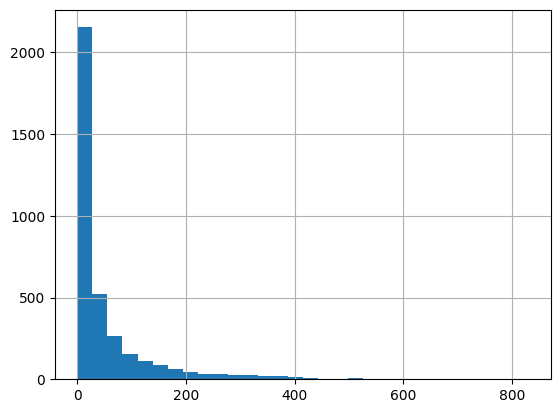

In [16]:
residuals.hist(bins=30)

## Predictions with filtered dataset

In [17]:
df = pd.read_parquet(DATASET_PATH).sort_values(['date', 'payment_channel'])

In [18]:
# We add the recognized sub-serie IDs and we remove the flagged noise
df['payment_channel'] = df['payment_channel'] + '_' + df['cluster_id'].astype(str)

if 'is_rec' in df.columns:
    df = df.loc[df.is_rec > 0]
else:
    df = df.loc[df.cluster_id >= 0]

In [19]:
%%time
X = build_features_date_pred(df)

CPU times: user 49.9 ms, sys: 2.04 ms, total: 52 ms
Wall time: 51.1 ms


/var/folders/t9/3dqqcds57z79th4nl53g_s6w0000gn/T/ipykernel_93059/3639142167.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  lambda x: stats.mode(x)[0][0]])
/var/folders/t9/3dqqcds57z79th4nl53g_s6w0000gn/T/ipykernel_93059/3639142167.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  X = eval_set_tmp\


In [20]:
print("Correlation between series modes and label:")
nonnan = ~(X[['mode', 'y_true']].isna().any(axis=1)).values
np.corrcoef(X['mode'].values[nonnan], X.y_true.values[nonnan])

Correlation between series modes and label:


array([[1.        , 0.26613553],
       [0.26613553, 1.        ]])

In [21]:
X_train, X_test = train_test_split(X)

In [22]:
MinMaxScaler().fit_transform(X_train.drop('y_true', axis=1)).shape

(60, 41)

In [23]:
X_train.drop('y_true', axis=1).shape

(60, 41)

In [24]:
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

# Define the pipeline with scaling
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', None)  # Placeholder for the model
])

# Perform cross-validation for each model
for m in models:
    print(f"Fitting {m}...")
    
    # Set the model in the pipeline
     # Set the model in the pipeline
    pipeline.set_params(model=m)
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_cv = []
    mape_cv = []
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index].drop('y_true', axis=1), X.iloc[test_index].drop('y_true', axis=1)
        y_train_fold, y_test_fold = X.iloc[train_index]['y_true'], X.iloc[test_index]['y_true']
        
        # Fit and predict on the fold
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipeline.predict(X_test_fold)
        
        # Calculate MAE and MAPE for the fold
        mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold)
        
        mae_cv.append(mae_fold)
        mape_cv.append(mape_fold)
        
    # Calculate mean and std of MAE for all folds
    mae_mean = np.mean(mae_cv)
    mae_std = np.std(mae_cv)
    
    # Calculate mean and std of MAPE for all folds
    mape_mean = np.mean(mape_cv)
    mape_std = np.std(mape_cv)
    
    print(f"Mean Absolute Error for {m}: {mae_mean:.5f} ± {mae_std:.5f}")
    print(f"Mean Absolute Percentage Error for {m}: {mape_mean:.5f} ± {mape_std:.5f}")
    
    print()

Fitting LinearRegression()...
Mean Absolute Error for LinearRegression(): 24.93152 ± 9.78736
Mean Absolute Percentage Error for LinearRegression(): 1.35975 ± 1.18295

Fitting GradientBoostingRegressor()...
Mean Absolute Error for GradientBoostingRegressor(): 13.78828 ± 5.89930
Mean Absolute Percentage Error for GradientBoostingRegressor(): 0.53129 ± 0.21246

Fitting RandomForestRegressor()...
Mean Absolute Error for RandomForestRegressor(): 12.76987 ± 3.85297
Mean Absolute Percentage Error for RandomForestRegressor(): 0.68264 ± 0.36340

Fitting DecisionTreeRegressor()...
Mean Absolute Error for DecisionTreeRegressor(): 15.20000 ± 6.01228
Mean Absolute Percentage Error for DecisionTreeRegressor(): 0.49912 ± 0.03527



In [25]:
%%time

# The same but with regular train/test split
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

for m in models:
    print(f"Fitting {m}...")
    scaler =  MinMaxScaler().fit(X_train.drop('y_true', axis=1))
    
    m = m.fit(
        scaler.transform(X_train.drop('y_true', axis=1)),
        y=X_train['y_true']
    )
    ypred = m.predict(
        scaler.transform(X_test.drop('y_true', axis=1)),
    )
    
    report = regression_report(X_test['y_true'], ypred)
    print(f"Report for {m} - {report}")
    
    print()

Fitting LinearRegression()...
Report for LinearRegression() - {'MAE': 22.850420730612406, 'MSE': 2153.181120945298, 'MAPE': 0.6688935519391281}

Fitting GradientBoostingRegressor()...
Report for GradientBoostingRegressor() - {'MAE': 17.74452737133408, 'MSE': 1588.4694808084803, 'MAPE': 0.3770603515524565}

Fitting RandomForestRegressor()...
Report for RandomForestRegressor() - {'MAE': 17.706, 'MSE': 1846.4202299999997, 'MAPE': 0.46575822376870013}

Fitting DecisionTreeRegressor()...
Report for DecisionTreeRegressor() - {'MAE': 16.05, 'MSE': 1385.65, 'MAPE': 0.2895466916282482}

CPU times: user 115 ms, sys: 1.94 ms, total: 117 ms
Wall time: 116 ms


In [26]:
residuals = np.abs(X_test['y_true'] - ypred)

print("Error Percentiles:")
for q in [0.05, 0.25, 0.5, 0.75, 0.95]:
    print(f"\tResiduals percentile {q} = {(residuals.quantile(q))}")

Error Percentiles:
	Residuals percentile 0.05 = 0.0
	Residuals percentile 0.25 = 1.0
	Residuals percentile 0.5 = 1.5
	Residuals percentile 0.75 = 2.0
	Residuals percentile 0.95 = 94.45000000000002


<Axes: >

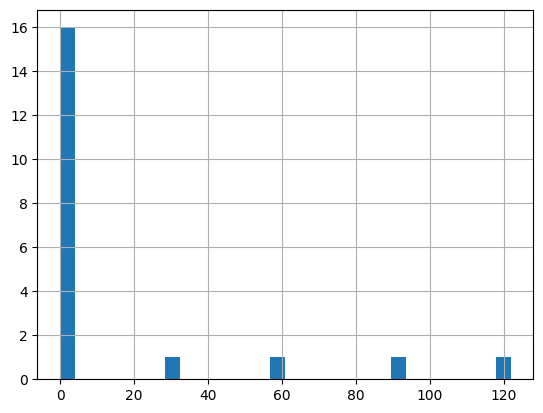

In [27]:
residuals.hist(bins=30)

Next amount prediction task
---

Predict the next movement amount

In [28]:
def build_features_amount_pred(df):
    eval_set = df.copy()

    eval_set = df.sort_values('date').groupby('payment_channel').nth(slice(0, -1)).sort_values('date')
    true_next_dates = df.sort_values('date').groupby('payment_channel').tail(1).set_index('payment_channel')

    # Days differences
    eval_set.loc[:, 'cumdiff']  = eval_set.groupby('payment_channel')['datediff'].cumsum().values
    eval_set.loc[:, 'cumbreaks'] = 0  # quick hack. This variable is useless   -> eval_set.groupby('payment_channel')['is_break'].cumsum().values
    eval_set.loc[:, 'cummovs']  = eval_set.groupby('payment_channel')['group_position'].diff().fillna(0).groupby('payment_channel').cumsum().values
    eval_set.loc[:, 'year_percent'] = eval_set.date.dt.day_of_year / 365
    
    # Percentiles
    historic_ranges = eval_set[(eval_set.datediff > 0)].groupby('payment_channel')['amount'].agg(['min', 'max', 
                                                                                                   percentile(5), percentile(50),percentile(95), 
                                                                                                   lambda x: stats.mode(x)[0][0]])
    historic_ranges = historic_ranges.rename({'<lambda_0>': 'mode'}, axis=1)

    ## TAKE ONLY N LAST MOVEMENTS
    eval_set_tmp = eval_set.groupby('payment_channel').tail(N_LAST_MOVS)
    
    eval_set_tmp = eval_set_tmp.sort_values(['payment_channel', 'date']).drop('group_position', axis=1)
    posid = eval_set_tmp.groupby(['payment_channel'])\
                .cumcount().rename('group_position')
    
    eval_set_tmp['group_position'] = posid
    eval_set_tmp = eval_set_tmp.reset_index().drop_duplicates(['payment_channel', 'group_position']).set_index('payment_channel')
    
    
    X = eval_set_tmp\
        .reset_index()[['payment_channel', 'group_position', 'amount', 'cumdiff', 'cumbreaks', 'cummovs', 'year_percent']]\
        .pivot('payment_channel', columns=["group_position"])
    
    X.columns = [f'amount_{i}' for i in range(N_LAST_MOVS)] +\
                [f'cumdiff_{i}' for i in range(N_LAST_MOVS)] +\
                [f'cumbreaks_{i}' for i in range(N_LAST_MOVS)] +\
                [f'cummovs_{i}' for i in range(N_LAST_MOVS)] +\
                [f'year_percent_{i}' for i in range(N_LAST_MOVS)]
    
    X = pd.merge(X, eval_set_tmp.loc[~eval_set_tmp.index.duplicated(keep='first')], left_index=True, right_index=True)
    
    # Add true label (target)
    X = X.join(true_next_dates['amount'].rename('y_true'))
    X = X.join(historic_ranges)

    X = X.loc[:, [c for c in X.columns if c not in blacklist]]

    return X.dropna()   # TODO: Check this nan

## Baseline: Predictions without filtering

In [29]:
df = pd.read_parquet(DATASET_PATH).sort_values(['date', 'payment_channel'])

In [30]:
X = build_features_amount_pred(df)

/var/folders/t9/3dqqcds57z79th4nl53g_s6w0000gn/T/ipykernel_93059/3272405687.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  lambda x: stats.mode(x)[0][0]])
/var/folders/t9/3dqqcds57z79th4nl53g_s6w0000gn/T/ipykernel_93059/3272405687.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  X = eval_set_tmp\


In [31]:
print("Correlation between series modes and label:")
nonnan = ~(X[['mode', 'y_true']].isna().any(axis=1)).values
np.corrcoef(X['mode'].values[nonnan], X.y_true.values[nonnan])

Correlation between series modes and label:


array([[1.       , 0.7826499],
       [0.7826499, 1.       ]])

In [32]:
X_train, X_test = train_test_split(X)

In [33]:
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

# Define the pipeline with scaling
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', None)  # Placeholder for the model
])

# Perform cross-validation for each model
for m in models:
    print(f"Fitting {m}...")
    
    # Set the model in the pipeline
     # Set the model in the pipeline
    pipeline.set_params(model=m)
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_cv = []
    mape_cv = []
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index].drop('y_true', axis=1), X.iloc[test_index].drop('y_true', axis=1)
        y_train_fold, y_test_fold = X.iloc[train_index]['y_true'], X.iloc[test_index]['y_true']
        
        # Fit and predict on the fold
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipeline.predict(X_test_fold)
        
        # Calculate MAE and MAPE for the fold
        mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold)
        
        mae_cv.append(mae_fold)
        mape_cv.append(mape_fold)
        
    # Calculate mean and std of MAE for all folds
    mae_mean = np.mean(mae_cv)
    mae_std = np.std(mae_cv)
    
    # Calculate mean and std of MAPE for all folds
    mape_mean = np.mean(mape_cv)
    mape_std = np.std(mape_cv)
    
    print(f"Mean Absolute Error for {m}: {mae_mean:.5f} ± {mae_std:.5f}")
    print(f"Mean Absolute Percentage Error for {m}: {mape_mean:.5f} ± {mape_std:.5f}")
    
    print()

Fitting LinearRegression()...
Mean Absolute Error for LinearRegression(): 217.78328 ± 15.80796
Mean Absolute Percentage Error for LinearRegression(): 1.82898 ± 0.15101

Fitting GradientBoostingRegressor()...
Mean Absolute Error for GradientBoostingRegressor(): 200.95834 ± 41.46951
Mean Absolute Percentage Error for GradientBoostingRegressor(): 1.07403 ± 0.02842

Fitting RandomForestRegressor()...
Mean Absolute Error for RandomForestRegressor(): 195.77873 ± 41.81228
Mean Absolute Percentage Error for RandomForestRegressor(): 0.94355 ± 0.02367

Fitting DecisionTreeRegressor()...
Mean Absolute Error for DecisionTreeRegressor(): 241.30588 ± 53.06010
Mean Absolute Percentage Error for DecisionTreeRegressor(): 1.11200 ± 0.03591



In [34]:
%%time

# The same but regular train/test split
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

for m in models:
    print(f"Fitting {m}...")
    scaler =  MinMaxScaler().fit(X_train.drop('y_true', axis=1))
    m = m.fit(
        scaler.transform(X_train.drop('y_true', axis=1)),
        y=X_train['y_true']
    )
    ypred = m.predict(
        scaler.transform(X_test.drop('y_true', axis=1)),
    )
    
    report = regression_report(X_test['y_true'], ypred)
    print(f"Report for {m} - {report}")
    
    print()

Fitting LinearRegression()...
Report for LinearRegression() - {'MAE': 251.86563413207801, 'MSE': 2032344.9744028817, 'MAPE': 1.5150178711232083}

Fitting GradientBoostingRegressor()...
Report for GradientBoostingRegressor() - {'MAE': 238.662086223396, 'MSE': 11216116.182783188, 'MAPE': 1.0245991064105593}

Fitting RandomForestRegressor()...
Report for RandomForestRegressor() - {'MAE': 247.12280488721808, 'MSE': 11382132.135000905, 'MAPE': 0.9441760390708477}

Fitting DecisionTreeRegressor()...
Report for DecisionTreeRegressor() - {'MAE': 282.2114044038668, 'MSE': 10771302.823821886, 'MAPE': 1.1552998028950865}

CPU times: user 29.8 s, sys: 1.39 s, total: 31.2 s
Wall time: 29.6 s


In [35]:
residuals = np.abs(X_test['y_true'] - ypred)

print("Error Percentiles:")
for q in [0.05, 0.25, 0.5, 0.75, 0.95]:
    print(f"\tResiduals percentile {q} = {(residuals.quantile(q))}")

Error Percentiles:
	Residuals percentile 0.05 = 0.19149999999999945
	Residuals percentile 0.25 = 6.152499999999999
	Residuals percentile 0.5 = 28.979999999999997
	Residuals percentile 0.75 = 129.34750000000003
	Residuals percentile 0.95 = 866.6349999999998


<Axes: >

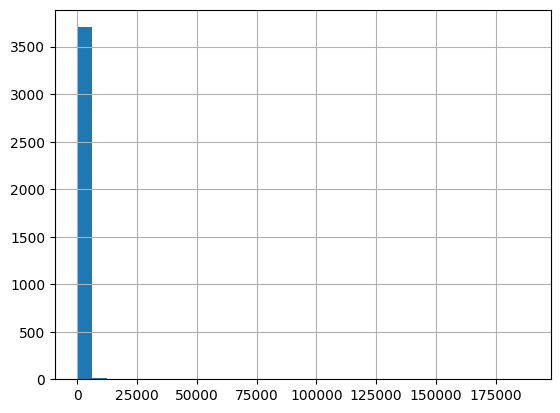

In [36]:
residuals.hist(bins=30)

## Predictions with filtered dataset

In [37]:
df = pd.read_parquet(DATASET_PATH).sort_values(['date', 'payment_channel'])

In [38]:
# We add the recognized sub-serie IDs and we remove the flagged noise
df['payment_channel'] = df['payment_channel'] + '_' + df['cluster_id'].astype(str)

if 'is_rec' in df.columns:
    df = df.loc[df.is_rec > 0]
else:
    df = df.loc[df.cluster_id >= 0]

In [39]:
%%time
X = build_features_amount_pred(df)

CPU times: user 51.8 ms, sys: 4.21 ms, total: 56 ms
Wall time: 55.9 ms


/var/folders/t9/3dqqcds57z79th4nl53g_s6w0000gn/T/ipykernel_93059/3272405687.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  lambda x: stats.mode(x)[0][0]])
/var/folders/t9/3dqqcds57z79th4nl53g_s6w0000gn/T/ipykernel_93059/3272405687.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  X = eval_set_tmp\


In [40]:
print("Correlation between series modes and label:")
nonnan = ~(X[['mode', 'y_true']].isna().any(axis=1)).values
np.corrcoef(X['mode'].values[nonnan], X.y_true.values[nonnan])

Correlation between series modes and label:


array([[1.        , 0.99999991],
       [0.99999991, 1.        ]])

In [48]:
X_train, X_test = train_test_split(X)

In [49]:
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

# Define the pipeline with scaling
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', None)  # Placeholder for the model
])

# Perform cross-validation for each model
for m in models:
    print(f"Fitting {m}...")
    
    # Set the model in the pipeline
     # Set the model in the pipeline
    pipeline.set_params(model=m)
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_cv = []
    mape_cv = []
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index].drop('y_true', axis=1), X.iloc[test_index].drop('y_true', axis=1)
        y_train_fold, y_test_fold = X.iloc[train_index]['y_true'], X.iloc[test_index]['y_true']
        
        # Fit and predict on the fold
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipeline.predict(X_test_fold)
        
        # Calculate MAE and MAPE for the fold
        mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold)
        
        mae_cv.append(mae_fold)
        mape_cv.append(mape_fold)
        
    # Calculate mean and std of MAE for all folds
    mae_mean = np.mean(mae_cv)
    mae_std = np.std(mae_cv)
    
    # Calculate mean and std of MAPE for all folds
    mape_mean = np.mean(mape_cv)
    mape_std = np.std(mape_cv)
    
    print(f"Mean Absolute Error for {m}: {mae_mean:.5f} ± {mae_std:.5f}")
    print(f"Mean Absolute Percentage Error for {m}: {mape_mean:.5f} ± {mape_std:.5f}")
    
    print()

Fitting LinearRegression()...
Mean Absolute Error for LinearRegression(): 7380268.70721 ± 11742666.37444
Mean Absolute Percentage Error for LinearRegression(): 12918.43261 ± 16646.14233

Fitting GradientBoostingRegressor()...
Mean Absolute Error for GradientBoostingRegressor(): 164.96919 ± 310.63551
Mean Absolute Percentage Error for GradientBoostingRegressor(): 0.03947 ± 0.01830

Fitting RandomForestRegressor()...
Mean Absolute Error for RandomForestRegressor(): 184.44056 ± 304.75107
Mean Absolute Percentage Error for RandomForestRegressor(): 0.89119 ± 1.22638

Fitting DecisionTreeRegressor()...
Mean Absolute Error for DecisionTreeRegressor(): 176.30320 ± 318.56818
Mean Absolute Percentage Error for DecisionTreeRegressor(): 0.06518 ± 0.02744



In [43]:
%%time

# The same but regular train/test split
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

for m in models:
    print(f"Fitting {m}...")
    scaler =  MinMaxScaler().fit(X_train.drop('y_true', axis=1))
    m = m.fit(
        scaler.transform(X_train.drop('y_true', axis=1)),
        y=X_train['y_true']
    )
    ypred = m.predict(
        scaler.transform(X_test.drop('y_true', axis=1)),
    )
    
    report = regression_report(X_test['y_true'], ypred)
    print(f"Report for {m} - {report}")
    
    print()

Fitting LinearRegression()...
Report for LinearRegression() - {'MAE': 2058380201.954744, 'MSE': 4.4004594814318895e+19, 'MAPE': 5143551.342549061}

Fitting GradientBoostingRegressor()...
Report for GradientBoostingRegressor() - {'MAE': 3.743161663604413, 'MSE': 30.65393528945137, 'MAPE': 0.022178120017214965}

Fitting RandomForestRegressor()...
Report for RandomForestRegressor() - {'MAE': 20.234139130434688, 'MSE': 2320.811300394781, 'MAPE': 0.5995456041166666}

Fitting DecisionTreeRegressor()...
Report for DecisionTreeRegressor() - {'MAE': 10.776521739130443, 'MSE': 364.68298260869614, 'MAPE': 0.03423193848574823}

CPU times: user 127 ms, sys: 2.29 ms, total: 130 ms
Wall time: 132 ms


In [44]:
residuals = np.abs(X_test['y_true'] - ypred)

print("Error Percentiles:")
for q in [0.05, 0.25, 0.5, 0.75, 0.95]:
    print(f"\tResiduals percentile {q} = {(residuals.quantile(q))}")

Error Percentiles:
	Residuals percentile 0.05 = 0.03999999999999776
	Residuals percentile 0.25 = 0.8000000000000114
	Residuals percentile 0.5 = 2.900000000000091
	Residuals percentile 0.75 = 16.75
	Residuals percentile 0.95 = 36.913000000000025


<Axes: >

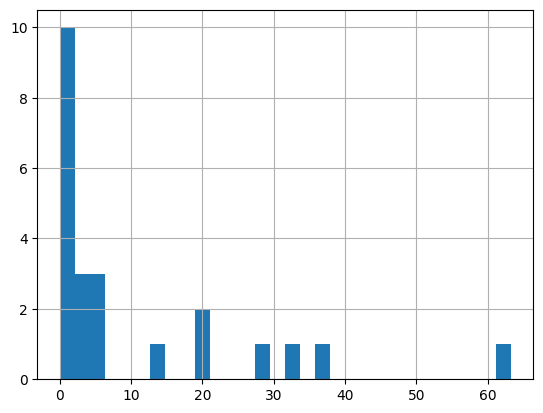

In [45]:
residuals.hist(bins=30)